In [ ]:
from utils.molec_class_files import r14, r32, r50, r125, r134a, r143a, r170, r41, r23, r161, r152a, r152, r134, r143, r116
from utils import atom_type, opt_atom_types
import numpy as np
import unyt as u
import pandas as pd
from fffit.fffit.utils import values_real_to_scaled, values_scaled_to_real, variances_scaled_to_real
from fffit.fffit.plot import plot_obj_contour
import os

In [ ]:
#Load class properies for each molecule
r14_class = r14.R14Constants()
r32_class = r32.R32Constants()
r50_class = r50.R50Constants()
r125_class = r125.R125Constants()
r134a_class = r134a.R134aConstants()
r143a_class = r143a.R143aConstants()
r170_class = r170.R170Constants()

r41_class = r41.R41Constants()
r23_class = r23.R23Constants()
r161_class = r161.R161Constants()
r152a_class = r152a.R152aConstants()
r152_class = r152.R152Constants()
r143_class = r143.R143Constants()
r134_class = r134.R134Constants()
r116_class = r116.R116Constants()

          This Work                            GAFF                       \
               MAPD       Min        Max       MAPD       Min        Max   
molecule                                                                   
R116       2.443667  0.796139   5.204234  27.656168  5.860258  48.244706   
R125       2.556171  0.180574   5.921953  19.652022  2.982102  39.211810   
R134a      2.010472  0.316541   4.870852   9.760699  3.612834  19.016568   
R14        1.019401  0.667739   1.654932  24.922472  4.399502  43.393125   
R143      14.131670  1.826224  34.250603   6.299411  2.183843  10.017708   

         Wang et al.                      
                MAPD       Min       Max  
molecule                                  
R116             NaN       NaN       NaN  
R125             NaN       NaN       NaN  
R134a       1.067455  0.317650  1.920738  
R14         1.116859  0.616981  1.697228  
R143             NaN       NaN       NaN  


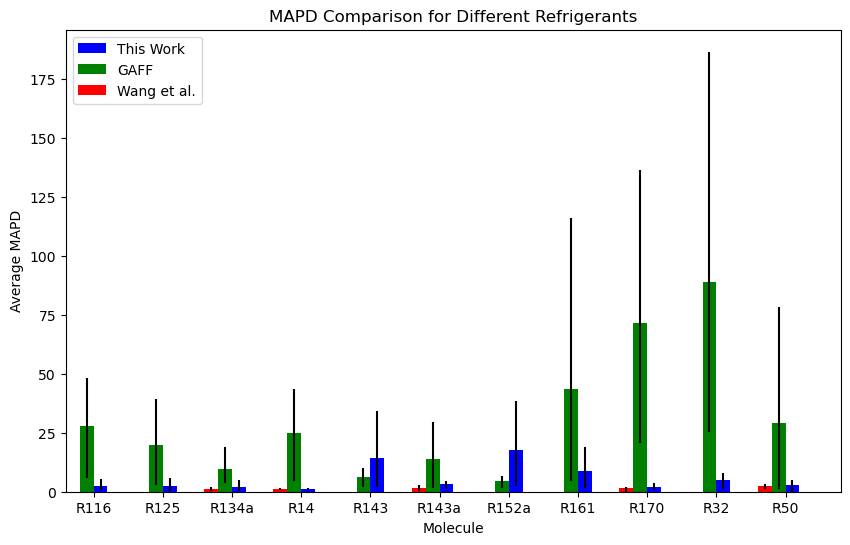

In [87]:
import matplotlib
import matplotlib.pyplot as plt

at_number = 11
cols = ["mapd_liq_density",	"mapd_vap_density",	"mapd_Pvap", "mapd_Hvap", "mapd_Tc", "mapd_rhoc"]
#Load our results, Gaff results, and old result MAPD values
gaff_err = pd.read_csv('Results_MS/gaff_ff_ms_err.csv', header = 0, index_col ="molecule")
nw_ffo_err = pd.read_csv('Results_MS/Wang_FFO_err.csv', header = 0, index_col ="molecule")
optff_err = pd.read_csv('Results_MS/at_' + str(at_number) + '/opt_ff_ms_err.csv', header = 0, index_col ="molecule")

# #Get Avg MAPD values for each molecule and each property + get min and max values
optff_avg = optff_err[cols].agg(['mean', 'min', 'max'], axis=1)
optff_avg.columns = ['MAPD', 'Min', 'Max']
gaff_avg = gaff_err[cols].agg(['mean', 'min', 'max'], axis=1)
gaff_avg.columns = ['MAPD', 'Min', 'Max']
nwffo_avg = nw_ffo_err[cols].agg(['mean', 'min', 'max'], axis=1)
nwffo_avg.columns = ['MAPD', 'Min', 'Max']

#Merge the dataframes
merged_df = pd.concat([optff_avg, gaff_avg, nwffo_avg], axis=1, keys=['This Work', 'GAFF', 'Wang et al.'])
merged_df.drop(["R41", "R23", "R152", "R134"], inplace = True)

# Plot the merged DataFrame
fig, ax = plt.subplots(figsize=(10, 6))

yerr_optff = [merged_df['This Work']['MAPD'] - merged_df['This Work']['Min'], merged_df['This Work']['Max'] - merged_df['This Work']['MAPD']]
yerr_GAFF = [merged_df['GAFF']['MAPD'] - merged_df['GAFF']['Min'], merged_df['GAFF']['Max'] - merged_df['GAFF']['MAPD']]
yerr_nwffo = [merged_df['Wang et al.']['MAPD'] - merged_df['Wang et al.']['Min'], merged_df['Wang et al.']['Max'] - merged_df['Wang et al.']['MAPD']]
merged_df['This Work']['MAPD'].plot(kind='bar', color='b', ax=ax, yerr =yerr_optff, position=0, width=0.2, label='This Work', rot = 0)
merged_df['GAFF']['MAPD'].plot(kind='bar', color='g', ax=ax, yerr =yerr_GAFF, position=1.0, width=0.2, label='GAFF', rot = 0)
merged_df['Wang et al.']['MAPD'].plot(kind='bar', color='r', ax=ax, yerr =yerr_nwffo, position=2.0, width=0.2, label='Wang et al.', rot = 0)

ax.set_title('MAPD Comparison for Different Refrigerants')
ax.set_xlabel('Molecule')
ax.set_xlim(-0.4, len(merged_df.index) - 0.2)
ax.set_ylabel('Average MAPD')
ax.legend(loc='upper left')

# Show the plot
plt.show()


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

#setup
obj_choice = "ExpVal"
molec_data_dict = {"R14":r14_class, "R32":r32_class, "R50":r50_class, "R170":r170_class, "R125":r125_class, "R134a":r134a_class, "R143a":r143a_class}
all_gp_dict = opt_atom_types.get_gp_data_from_pkl(list(molec_data_dict.keys()))

#For each AT, get best MAPD list
at_list = [11,12,13,14]

x = np.arange(len(molec_data_dict))  # the label locations
width = 0.2 #1/len(x+1)  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()
for at in at_list:
    at_class = atom_type.make_atom_type_class(at)
    setup = opt_atom_types.Problem_Setup(molec_data_dict, all_gp_dict, at_class, obj_choice)
    dir_name = setup.make_results_dir(list(molec_data_dict.keys()))
    df = pd.read_csv(dir_name+"/MAPD_best_set.csv", header = 0)

    if at == 11:
        litdf = df[df['Model'] == "Literature"]
        litdf = litdf.groupby('Molecule')['MAPD'].agg(['mean', 'min', 'max']).reset_index()
        litdf.columns = ['Molecule', 'Avg MAPD', 'Min MAPD', 'Max MAPD']
        offset = width * multiplier
        rects2 = ax.bar(x + offset, litdf["Avg MAPD"], width, label="Literature")
        maxy = litdf["Max MAPD"] - litdf["Avg MAPD"]
        miny = litdf["Avg MAPD"] - litdf["Min MAPD"]
        ax.errorbar(x + offset, litdf["Avg MAPD"], yerr=[miny, maxy], fmt=".k")
        multiplier += 1

    #Get only best opt values
    filtered_df = df[df['Model'] == 'Opt R14-R32-R50-R170-R125-R134a-R143a']
    sorted_df = filtered_df.sort_values(by='MAPD', ascending = False).reset_index(drop = True)
    average_df = sorted_df.groupby('Molecule')['MAPD'].agg(['mean', 'min', 'max']).reset_index()
    average_df.columns = ['Molecule', 'Avg MAPD', 'Min MAPD', 'Max MAPD']
    offset = width * multiplier
    rects = ax.bar(x + offset, average_df["Avg MAPD"], width, label="at_" + str(at))
    maxy = average_df["Max MAPD"] - average_df["Avg MAPD"]
    miny = average_df["Avg MAPD"] - average_df["Min MAPD"]
    ax.errorbar(x + offset, average_df["Avg MAPD"],yerr=[miny, maxy], fmt=".k")
    # ax.bar_label(rects, padding=3)
    multiplier += 1
    

ax.axhline(y=5, label="5% MAPD", color = "black", linestyle = "--")
    
#Filter out non-full atscheme results
#Plot
# ax.set_xticks(x + width )
ax.set_xticks(x + width, list(average_df["Molecule"]))
ax.set_ylabel("Average MAPD")
ax.grid()
plt.legend(loc='upper left')
plt.show()

In [ ]:
#Get Setup properties
at_class = atom_type.AT_Scheme_11()
w_calc = 2
save_data = False
obj_choice = "ExpVal"
molec_data_dict = {"R14":r14_class, "R32":r32_class, "R50":r50_class, "R170":r170_class, "R125":r125_class, "R134a":r134a_class, "R143a":r143a_class}
molec_data_dict = {"R134a":r134a_class}
molec_test_data_dict = {"R134a":r134a_class}
all_gp_dict = opt_atom_types.get_gp_data_from_pkl(list(molec_data_dict.keys()))
setup = opt_atom_types.Problem_Setup(molec_data_dict, all_gp_dict, at_class, obj_choice)
param_matrix = at_class.get_transformation_matrix(molec_test_data_dict)
all_molec_dir = setup.make_results_dir(list(molec_data_dict.keys()))
all_df = pd.read_csv(all_molec_dir+"/best_per_run.csv", header = 0)
all_df = pd.read_csv(all_molec_dir+"/best_per_run.csv", header = 0)
sorted_df = all_df.sort_values(by='Min Obj', ascending = True).reset_index(drop = True)
first_param_name = setup.at_class.at_names[0] + "_min"
last_param_name = setup.at_class.at_names[-1] + "_min"
full_opt_best = all_df.loc[0, first_param_name:last_param_name]
print(full_opt_best)
# print(sorted_df.loc[0, "Min Obj"])
# print(sorted_df.loc[0, "Message"])
all_best_real = setup.values_pref_to_real(full_opt_best.values)
all_best_nec = full_opt_best.values.reshape(-1,1).T@param_matrix
print(all_best_nec)
# all_best_gp = values_real_to_scaled(all_best_nec.reshape(1,-1), setup.all_molec_data[list(molec_test_data_dict.keys())[0]].param_bounds)

In [ ]:
#Visualize property predictions for training data
molec_data_dict = {"R14":r14_class, "R32":r32_class, "R50":r50_class, "R170":r170_class, "R125":r125_class, "R134a":r134a_class, "R143a":r143a_class}
all_gp_dict = opt_atom_types.get_gp_data_from_pkl(list(molec_data_dict.keys()))
visual = opt_atom_types.Vis_Results(molec_data_dict, all_gp_dict, at_class, obj_choice)
molec_names = list(["R14", "R32", "R50", "R170", "R125", "R134a", "R143a"])
# visual.comp_paper_full_ind(molec_names)
#Calculate MAPD for predictions
df = pd.read_csv(all_molec_dir+"/MAPD_best_set.csv", header = 0)
df.head()

In [ ]:
#Sort MAPD values from above df
filtered_df = df[df['Model'] == 'Opt R14-R32-R50-R170-R125-R134a-R143a']
# filtered_df = df[df['Model'] != 'Literature']
sorted_df = filtered_df.sort_values(by='MAPD', ascending = False).reset_index(drop = True)
average_df = filtered_df.groupby('Molecule')['MAPD'].mean().reset_index()
average_df.rename(columns={'MAPD': 'Avg MAPD'}, inplace=True)
average_df
avg_df = average_df.sort_values(by='Avg MAPD', ascending = True).reset_index(drop = True)
avg_df
# df.to_csv("MAPD_best.csv", index = False, header = True)

In [ ]:
import scipy 
import os
repeats = 1
seed = 1
#Get obj from a set of parameters
molec_data_dict = {"R14":r14_class, "R32":r32_class, "R50":r50_class, "R170":r170_class, "R125":r125_class, "R134a":r134a_class, "R143a":r143a_class}
molec_data_dict = {"R143a":r143a_class}
all_gp_dict = opt_atom_types.get_gp_data_from_pkl(list(molec_data_dict.keys()))
at_optimizer =  opt_atom_types.Opt_ATs(molec_data_dict, all_gp_dict, at_class, repeats, seed, obj_choice)
# all_molec_dir = setup.make_results_dir(list(molec_data_dict.keys()))
# all_df = pd.read_csv(all_molec_dir+"/best_per_run.csv", header = 0)
# sorted_df = all_df.sort_values(by='Min Obj', ascending = True).reset_index(drop = True)
# first_param_name = setup.at_class.at_names[0] + "_min"
# last_param_name = setup.at_class.at_names[-1] + "_min"
# best_pref = all_df.loc[0, first_param_name:last_param_name].values()
# best_pref = np.array([3.3965664266801703,3.440648986884316,2.0002287496346898,1.9895617598434474,2.8455549929882973,2.1846771895375956,2.929597585178781,42.15585471681824,35.789885824993554,45.023087710218206,10.000000000000002,42.82067021601047,22.155828740603113,28.599458026860685])
# best_pref = np.array([3.563847649565008, 3.7023297804578013, 3.383454561616988, 2.501869323173524, 2.8016532687774456, 2.9570560025914276, 2.938081818350493, 47.955100549476825, 42.9383601572982, 51.7928754827407, 9.956251656605064, 39.956127381108494, 28.664773473001603, 24.34860285294489]
# )
# best_pref = np.array([3.727,3.810,3.754, 3.028,3.809,
#                       2.316,
#                       2.607,3.255,3.424,2.917,
#                       71.730,52.200, 72.610,53.690,69.970,
#                       6.160,
#                       39.980,20.164, 17.050, 29.070])
# best_real= at_optimizer.values_pref_to_real(best_pref)
# obj = at_optimizer.calc_obj(best_real)
# print(obj[0])

#Get Jac and Hess info from a set of parameters
# dir_name = at_optimizer.make_results_dir(list(at_optimizer.molec_data_dict.keys()))
# save_path = os.path.join(dir_name, "best_set" + "_hess_approx.npy")
# hess = np.load(save_path)
# print(hess.shape)
# jac = at_optimizer.approx_jac(best_real)
# hess = at_optimizer.approx_hess(best_real)
# print(scipy.linalg.norm(jac, ord = np.inf))
# print(jac)
# print(hess)
# eigval, eigvec = scipy.linalg.eig(hess)
# print(eigval)

In [ ]:
# print(eigvec)
# eig_val_path = os.path.join(dir_name, "Hess_EigVals")
# eig_vec_path = os.path.join(dir_name, "Hess_EigVecs")
# eigval = [np.real(num) for num in eigval]
# np.savetxt(eig_val_path,eigval,delimiter=",")
# np.savetxt(eig_vec_path,eigvec,delimiter=",")

In [ ]:
#Get Uncertainty data
molec_data_dict = {"R14":r14_class, "R32":r32_class, "R50":r50_class, "R170":r170_class, "R125":r125_class, "R134a":r134a_class, "R143a":r143a_class}
df = pd.DataFrame(columns = ["Molecule", "Property", "Value", "Uncertainty", "Uncertainty Used", "Weight"])
for key in list(molec_data_dict.keys()):
    molec_object = molec_data_dict[key]
    for prop_key in list(molec_object.uncertainties.keys()):
        if "vap_density" in prop_key:
            exp_data = molec_object.expt_vap_density
            property_bounds = molec_object.vap_density_bounds
            property_name = "Vapor Density [kg/m^3]"
        elif "liq_density" in prop_key:
            exp_data = molec_object.expt_liq_density
            property_bounds = molec_object.liq_density_bounds
            property_name = "Liquid Density [kg/m^3]"
        elif "Pvap" in prop_key: 
            exp_data = molec_object.expt_Pvap
            property_bounds = molec_object.Pvap_bounds
            property_name = "Vapor pressure [bar]"
        elif "Hvap" in prop_key:
            exp_data = molec_object.expt_Hvap
            property_bounds = molec_object.Hvap_bounds
            property_name = "Enthalpy of Vaporization [kJ/kg]"

        values = np.array(list(exp_data.values()))
        y_unc = molec_object.uncertainties[prop_key]
        unc_val = np.maximum(y_unc, 0.02)
        weight = 1/(unc_val*values)**2
        df_vals = [key, prop_key, values, y_unc, unc_val, weight]
        iter_df = pd.DataFrame([df_vals], columns = df.columns)
        iter_df = iter_df.apply(lambda col: col.explode(), axis=0).reset_index(drop=True).copy(deep =True)
        df = pd.concat([df, iter_df], ignore_index=True)
df.to_csv("molecule_exp_unc_data.csv", index = False, header = True)